In [2]:
import functools as ft
import json
import os
from pathlib import Path
from typing import Any

import equinox as eqx
import jax.numpy as jnp
import jax.profiler
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from einops import rearrange, repeat
from ipywidgets import interact
from jax import config, device_count, random
from jax.scipy.optimize import minimize
from numpyencoder import NumpyEncoder
from scipy import constants

from jackpot.config import Config, JaxPlatform
from jackpot.fitting import SaturatingExponential
from jackpot.modules import AutocorrelationData
from jackpot.primitives.autocorrelate import acf
from jackpot.primitives.utils import beta_to_temp
from jackpot.state import Environment, Measurement, State
from jackpot.types import Algorithm
from jackpot.typing import RNGKey
from jackpot.utils.map import filter_map
from jackpot.utils.pbar import make_scan
from jackpot.utils.random import EasyKey

%load_ext autoreload
%autoreload 2

In [3]:
assert os.cpu_count() == 96

In [4]:
PAPERMILL: bool = False
PAPERMILL_INPUT_PATH: str = ""
PAPERMILL_OUTPUT_PATH: str = ""

In [5]:
# base
JAX_PLATFORM: JaxPlatform = JaxPlatform.CPU
DO_PROFILING: bool = False
ENABLE_64_BIT: bool = False
DO_AUTOCORRELATION: bool = False

# experiment
RNG_SEED: int = 0
SPIN: float = 0.5
DIMENSIONS: int = 2
SIZE: int = 32
TOTAL_SAMPLES: int = 384
N_SAMPLES_VECTORISE: int = 2
LOOP_N_TEMPS_Y: bool = False


# environment
INTERACTION_BILINEAR: float = 1.0
INTERACTION_BIQUADRATIC: float = 0.0
INTERACTION_ANISOTROPY: float = 0.0
INTERACTION_BICUBIC: float = 0.0
INTERACTION_EXTERNAL_FIELD: float = 0.0
NUCLEAR_MAGNETIC_MOMENT: float = 1.0

# environment config
ALGORITHM: Algorithm = Algorithm.METROPOLIS_HASTINGS
PROBABILISTIC_CLUSTER_ACCEPT: bool = False

# temperatures
TEMP_MIN: float = 0.80
TEMP_MAX: float = 1.90
N_TEMPS: int = 96

# thermalisation
THERMALISE_STEPS: int = 50
THERMALISE_SWEEPS_PER_STEP: int = 50

# autocorrelation
AUTOCORRELATION_STEPS: int = 100
AUTOCORRELATION_SWEEPS_PER_STEP: int = 1

# measure
MEASURE_EQUILIBRIUM_STEPS: int = 10
MEASURE_EQUILIBRIUM_NUM: int = 4
MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP: int = 25

In [6]:
# TPU + high dim
# if not PAPERMILL:
#     JAX_PLATFORM = JaxPlatform.TPU
#     ALGORITHM = Algorithm.WOLFF
#     N_TEMPS = 32
#     TOTAL_SAMPLES = N_TEMPS * 4
#     LOOP_N_TEMPS_Y = True
#     N_SAMPLES_VECTORISE = 1

# DIMENSIONS = 4
# SIZE = 32

# TEMP_MIN = 6.0 / 2
# TEMP_MAX = 6.8 / 2

# THERMALISE_STEPS: int = 100
# THERMALISE_SWEEPS_PER_STEP: int = 100

In [7]:
# # CPU + Quick
# if not PAPERMILL:
#     JAX_PLATFORM = JaxPlatform.CPU
#     ALGORITHM = Algorithm.WOLFF
#     N_TEMPS = 96 * 2
#     TOTAL_SAMPLES = 96 * 2 * 2 * 2
#     LOOP_N_TEMPS_Y = False
#     N_SAMPLES_VECTORISE = 2

#     DIMENSIONS = 2
#     SIZE = 32

#     # TEMP_MIN = 6.0 / 2
#     # TEMP_MAX = 6.8 / 2

#     THERMALISE_STEPS: int = 25
#     THERMALISE_SWEEPS_PER_STEP: int = 100

In [8]:
# if not PAPERMILL:
#     ...
#     JAX_PLATFORM = JaxPlatform.TPU
#     ALGORITHM = Algorithm.WOLFF
#     N_TEMPS = 32
#     TOTAL_SAMPLES: int = 128
#     N_SAMPLES_VECTORISE = 1

#     DIMENSIONS = 3

#     # TEMP_MIN = 2.1
#     # TEMP_MAX = 2.7
#     SIZE = 64
#     TOTAL_SAMPLES = N_TEMPS
# TEMP_MIN = 6.0
# TEMP_MAX = 6.8

In [9]:
#! Papermill-like
if not PAPERMILL:
    # PAPERMILL = True
    RNG_SEED = 1
    JAX_PLATFORM = JaxPlatform.CPU
    ALGORITHM = Algorithm.METROPOLIS_HASTINGS
    DIMENSIONS = 2
    SPIN = 0.5
    TOTAL_SAMPLES = 768
    N_TEMPS = 96
    N_SAMPLES_VECTORISE = 8
    THERMALISE_STEPS = 100
    THERMALISE_SWEEPS_PER_STEP = 100
    TEMP_MIN = 1.0
    TEMP_MAX = 2.5
    SIZE = 16

In [10]:
Path().resolve()

PosixPath('/home/jeppe/JaxIsingModel')

In [11]:
# Post init
if PAPERMILL:
    from tqdm.std import tqdm
else:
    from tqdm.notebook import tqdm

if PAPERMILL_OUTPUT_PATH:
    SAVE_PATH = Path(PAPERMILL_OUTPUT_PATH).parent.resolve()
else:
    SAVE_PATH = (Path() / "experiments" / "last").resolve()
to_save: dict[str, Any] = {}

print(f"{SAVE_PATH=}")

_CONFIG_VARS = [
    "JAX_PLATFORM",
    "DO_PROFILING",
    "ENABLE_64_BIT",
    "DO_AUTOCORRELATION",
    "RNG_SEED",
    "SPIN",
    "DIMENSIONS",
    "SIZE",
    "TOTAL_SAMPLES",
    "N_SAMPLES_VECTORISE",
    "LOOP_N_TEMPS_Y",
    "THERMALISE_STEPS",
    "THERMALISE_SWEEPS_PER_STEP",
    "INTERACTION_BILINEAR",
    "INTERACTION_BIQUADRATIC",
    "INTERACTION_ANISOTROPY",
    "INTERACTION_BICUBIC",
    "INTERACTION_EXTERNAL_FIELD",
    "NUCLEAR_MAGNETIC_MOMENT",
    "ALGORITHM",
    "PROBABILISTIC_CLUSTER_ACCEPT",
    "TEMP_MIN",
    "TEMP_MAX",
    "N_TEMPS",
    "AUTOCORRELATION_STEPS",
    "AUTOCORRELATION_SWEEPS_PER_STEP",
    "MEASURE_EQUILIBRIUM_STEPS",
    "MEASURE_EQUILIBRIUM_NUM",
    "MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP",
]

_CONFIG_DICT = {}

for var in _CONFIG_VARS:
    _CONFIG_DICT[var.lower()] = globals()[var]
    del globals()[var]

c = Config(**_CONFIG_DICT)

with open(SAVE_PATH / "config.json", "w") as f:
    f.write(c.json(indent=4))


# ---
match c.jax_platform:
    case JaxPlatform.CPU:
        config.update("jax_platform_name", "cpu")
        config.update("jax_platforms", "cpu")

        # CPU cores as separate devices
        os.environ[
            "XLA_FLAGS"
        ] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

    case JaxPlatform.TPU:
        config.update("jax_platform_name", "tpu")
        config.update("jax_platforms", "tpu")

        from jax.experimental.compilation_cache import compilation_cache

        compilation_cache.initialize_cache("/tmp/xla_comp_cache")

        # SEE: https://github.com/google/jax/discussions/12001#discussioncomment-3467948
        os.environ["LIBTPU_INIT_ARGS"] = "--xla_tpu_spmd_rng_bit_generator_unsafe=1"
        config.update("jax_default_prng_impl", "unsafe_rbg")

    case JaxPlatform.GPU:
        config.update("jax_platform_name", "gpu")
        config.update("jax_platforms", "gpu")

    case _:
        raise ValueError("Invalid JaxPlatform")

# config.update("jax_check_tracer_leaks", True)
if c.enable_64_bit:
    config.update("jax_enable_x64", True)

matplotlib.rcParams["figure.figsize"] = (10, 10)

if "_PROFILER_IS_RUNNING" not in globals() and c.do_profiling:
    _PROFILER_IS_RUNNING = True
    jax.profiler.start_server(9999)

SAVE_PATH=PosixPath('/home/jeppe/JaxIsingModel/experiments/last')


In [12]:
# Init

DEVICE_COUNT = device_count()
to_save["DEVICE_COUNT"] = DEVICE_COUNT
rng_seed = c.rng_seed if c.rng_seed is not None else np.random.randint(0, 10**10)
to_save["rng_seed"] = rng_seed
k = EasyKey(rng_seed)
rng_key = k.new

ENVIRONMENT_BASE_PARAMS = {
    "interaction_bilinear": c.interaction_bilinear,
    "interaction_biquadratic": c.interaction_biquadratic,
    "interaction_anisotropy": c.interaction_anisotropy,
    "interaction_bicubic": c.interaction_bicubic,
    "interaction_external_field": c.interaction_external_field,
    "nuclear_magnetic_moment": c.nuclear_magnetic_moment,
    "algorithm": c.algorithm,
    "probabilistic_cluster_accept": c.probabilistic_cluster_accept,
}

if c.n_temps < DEVICE_COUNT:
    raise ValueError(f"Should have at least {DEVICE_COUNT} temperatures")
N_TEMPS_X = DEVICE_COUNT
N_TEMPS_Y = c.n_temps // N_TEMPS_X
to_save["N_TEMPS_X"] = N_TEMPS_X
to_save["N_TEMPS_Y"] = N_TEMPS_Y

if not N_TEMPS_X * N_TEMPS_Y == c.n_temps:
    raise ValueError(f"Temperatures should be a multiple of {DEVICE_COUNT}")

N_SAMPLES_PER_TEMP = c.total_samples // (N_TEMPS_X * N_TEMPS_Y)
N_SAMPLES_LOOP = N_SAMPLES_PER_TEMP // c.n_samples_vectorise
to_save["N_SAMPLES_PER_TEMP"] = N_SAMPLES_PER_TEMP
to_save["N_SAMPLES_LOOP"] = N_SAMPLES_LOOP

VECTORISATION_SHAPE = (N_SAMPLES_LOOP, N_TEMPS_X, N_TEMPS_Y, c.n_samples_vectorise)

print(f"Temperatures: {c.n_temps:_}")
print(f"{c.n_temps=}")
print(f"{N_TEMPS_X=}")
print(f"{N_TEMPS_Y=}")
print(f"{N_SAMPLES_PER_TEMP=}")
print(f"--{c.n_samples_vectorise=}")
print(f"--{N_SAMPLES_LOOP=}")

if not N_SAMPLES_LOOP * c.n_samples_vectorise == N_SAMPLES_PER_TEMP:
    raise ValueError(
        "Failed to factorise in a good way. " f"Factors: {VECTORISATION_SHAPE}"
    )
to_save["VECTORISATION_SHAPE"] = VECTORISATION_SHAPE

VECTORISED_COUNT = np.prod(VECTORISATION_SHAPE)
to_save["VECTORISED_COUNT"] = VECTORISED_COUNT
print(f"Vectorised count: {VECTORISED_COUNT:_}")

if not VECTORISED_COUNT == c.total_samples:
    raise ValueError(
        f"Got bad vectorised count: {VECTORISED_COUNT=} != {c.total_samples=}"
    )

TOTAL_SWEEPS = VECTORISED_COUNT * c.thermalise_sweeps_per_step * c.thermalise_steps
to_save["TOTAL_SWEEPS"] = TOTAL_SWEEPS
print(f"Total sweeps: {TOTAL_SWEEPS:_}")

BETA_MIN = 1.0 / c.temp_max
BETA_MAX = 1.0 / c.temp_min
betas = np.geomspace(BETA_MIN, BETA_MAX, c.n_temps)


def transforms(in_axes, out_axes=0):
    def inner(fun):
        fun = eqx.filter_jit(fun)

        # SAMPLES_VECTORISE
        fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_Y
        if c.loop_n_temps_y:
            fun = filter_map(fun)
        else:
            fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_X
        fun = eqx.filter_pmap(fun, in_axes=in_axes, out_axes=out_axes)

        # SAMPLES_LOOP
        fun = filter_map(fun)

        return fun

    return inner


def calculate_known_total(steps: int) -> int:
    total = steps
    total *= N_SAMPLES_LOOP
    total *= N_TEMPS_X

    if c.loop_n_temps_y:
        total *= N_TEMPS_Y

    return total

Temperatures: 96
c.n_temps=96
N_TEMPS_X=96
N_TEMPS_Y=1
N_SAMPLES_PER_TEMP=8
--c.n_samples_vectorise=8
--N_SAMPLES_LOOP=1
Vectorised count: 768
Total sweeps: 7_680_000


In [13]:
# # Single state
# env = Environment.from_spin(spin=c.spin, beta=1.0, **ENVIRONMENT_BASE_PARAMS)
# state = State.uniform_random_square_from_env(
#     rng_key=k.new, dimensions=c.dimensions, size=c.size, env=env, id_=0
# )

# # state = state.evolve_steps(1000, rng_key=k.new)
# initial_state = state
# state = state.evolve_sweeps(rng_key=k.new, sweeps=1)
# # measured = state.measure(rng_key=k.new, num=1, sweeps=10)

# state.calculate_energy()
# state.calculate_magnetisation_density()

# Thermalisation

In [17]:
@transforms(in_axes=(0, None, None, None, 0, 0, None, None, None, None))
def make_and_thermalise_states(
    rng_key: RNGKey,
    spin: float,
    dimensions: int,
    size: int,
    beta: float,
    id_: int,
    steps: int,
    sweeps_per_step: int,
    kwargs: dict[str, Any],
    num_prints: int = 10,
):
    # Make state
    env = Environment.from_spin(
        spin=spin,
        beta=beta,
        **kwargs,
    )

    rng_key, state_key = random.split(key=rng_key, num=2)

    state = State.minimum_square_from_env(
        rng_key=state_key, dimensions=dimensions, size=size, env=env, id_=id_
    )

    def evolve_and_measure(state: State, x: RNGKey) -> tuple[State, Measurement]:
        _key = x
        state = state.evolve_sweeps(rng_key=_key, sweeps=sweeps_per_step)
        measurement = state.measure()

        return state, measurement

    keys = random.split(rng_key, num=steps)
    scan = make_scan(
        tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
    )
    state, measurements = scan(f=evolve_and_measure, init=state, xs=keys)

    return state, measurements


_betas = rearrange(betas, "(x y) -> x y", x=N_TEMPS_X, y=N_TEMPS_Y)
_betas = repeat(
    _betas,
    "x y -> s_loop x y s_vec",
    s_vec=c.n_samples_vectorise,
    s_loop=N_SAMPLES_LOOP,
)
shape = _betas.shape
print(f"{shape=}")

ids = np.arange(np.prod(shape)).reshape(shape)


# rng_key: RNGKey
# spin: float
# dimensions: int
# size: int
# beta: float
# id_: int
# steps: int
# sweeps_per_step: int
# kwargs: dict[str, Any]
# num_prints: int = 10
state_keys = k.shaped(shape)
thermalise_num_prints = 5
states, evolve_measurements = make_and_thermalise_states(
    state_keys,
    c.spin,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    ENVIRONMENT_BASE_PARAMS,
    thermalise_num_prints,
)

states.block_until_ready()
eqx.tree_serialise_leaves(SAVE_PATH / "states.eqx", states)

shape=(1, 96, 1, 8)


/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function scan includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

  0%|          | 0/9600 [00:00<?, ?it/s]

2023-04-20 11:45:24.865003: E external/xla/xla/service/collective_ops_utils.h:224] This thread has been waiting for 5000ms for and may be stuck: participant AllReduceParticipantData{buffers=[{element_count=196608}], rendezvous_key=RendezvousKey{run_id=RunId: 1840590, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95], num_local_participants=96, collective_op_kind=cross_replica, op_id=54}, device_ordinal=57, stream=(nil)} waiting for all participants to arrive at rendezvous RendezvousKey{run_id=RunId: 1840590, global_devices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,7

In [ ]:
evolve_meas_df = evolve_measurements.to_df()
raise ValueError

,steps,sweeps,state_id,energy,magnetisation_density
0,25600,100,0,-54.0,-0.039062
0,51200,200,0,-48.0,0.074219
0,76800,300,0,-64.0,0.070312
0,102400,400,0,-50.0,-0.066406
0,128000,500,0,-40.0,-0.007812
...,...,...,...,...,...
767,2457600,9600,767,-238.0,-0.472656
767,2483200,9700,767,-200.0,-0.398438
767,2508800,9800,767,-228.0,-0.464844
767,2534400,9900,767,-206.0,-0.437500


In [15]:
evolve_meas_df = evolve_measurements.to_df()
evolve_meas_df = evolve_meas_df.explode(evolve_meas_df.columns.tolist()).infer_objects()


@ft.cache
def id_to_beta(id_):
    idx = np.argwhere(states.id_ == id_).flatten()
    idx = tuple(idx)
    return float(states.env.beta[idx])


evolve_meas_df["beta"] = evolve_meas_df["state_id"].apply(id_to_beta)
evolve_meas_df["temp"] = beta_to_temp(evolve_meas_df["beta"], human=True)
evolve_meas_df["abs_magnetisation_density"] = np.abs(
    evolve_meas_df["magnetisation_density"]
)

KeyboardInterrupt: 

In [ ]:
# Fit saturating decay times to quantifiably understand whether we have fully thermalised
def fit_thermalisation(group):
    x = group["sweeps"]
    y = group["energy"]

    amplitude = np.max(y) - np.min(y)
    decay = np.max(x)
    offset = y.iloc[-1]

    params = SaturatingExponential.make_params()
    params["amplitude"].set(amplitude)
    params["decay"].set(decay, min=0, max=np.inf)
    params["c"].set(offset)

    fit = SaturatingExponential.fit(y, params, x=x)

    assert np.ptp(group["temp"]) == 0.0

    return pd.Series(
        {
            "temp": group["temp"].iloc[0],
            "therm_amplitude": fit.params["amplitude"].value,
            "therm_amplitude_sd": fit.params["amplitude"].stderr,
            "therm_decay": fit.params["decay"].value,
            "therm_decay_sd": fit.params["decay"].stderr,
            "therm_offset": fit.params["c"].value,
            "therm_offset_sd": fit.params["c"].stderr,
        }
    )


evolve_meas_fit_df = evolve_meas_df.groupby("state_id", as_index=False).apply(
    fit_thermalisation
)
# evolve_meas_df = pd.concat([evolve_meas_df, _new_cols])
# _new_cols


def _has_thermalised():
    high_temp_df = evolve_meas_fit_df[
        evolve_meas_fit_df["temp"] == evolve_meas_fit_df["temp"].max()
    ]
    therm_check_df = high_temp_df[
        high_temp_df["therm_decay"] > 4.0 * high_temp_df["therm_decay_sd"]
    ]

    # We have no data to check probably because system is very very thermalised
    # and thus has no data to fit to exponential
    if not len(therm_check_df):
        return True

    longest_decay = therm_check_df["therm_decay"].max()
    print(longest_decay)
    if evolve_meas_df["sweeps"].max() > 6.0 * longest_decay:
        return True

    return False


has_thermalised = _has_thermalised()
has_thermalised

True

In [ ]:
evolve_meas_df.reset_index().to_feather(SAVE_PATH / "evolve_meas_df.feather")

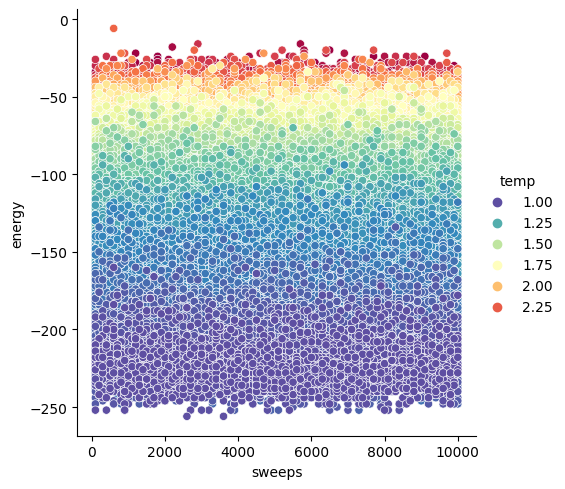

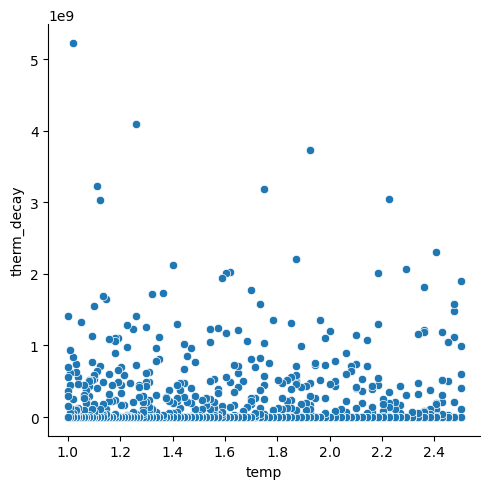

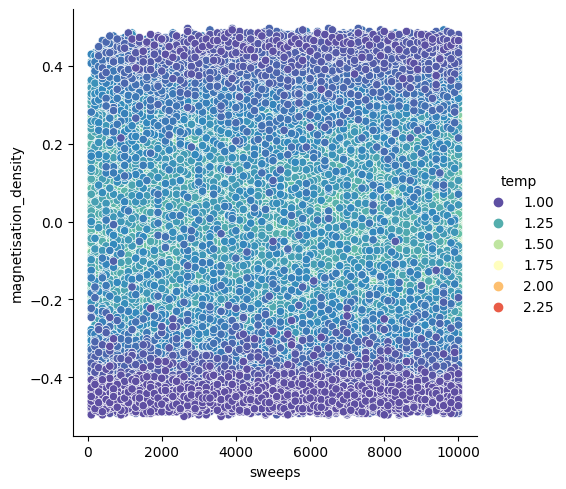

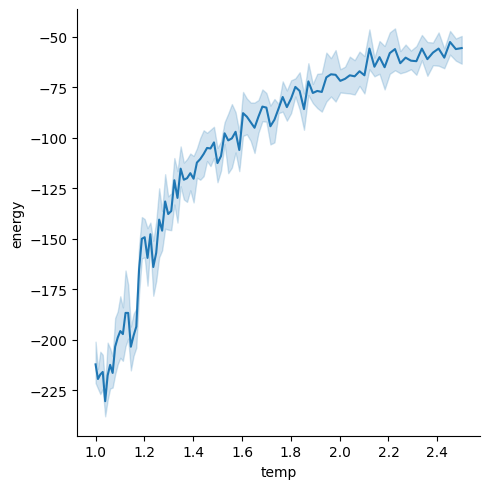

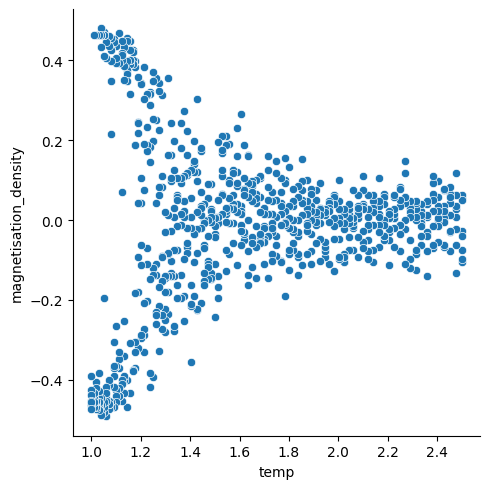

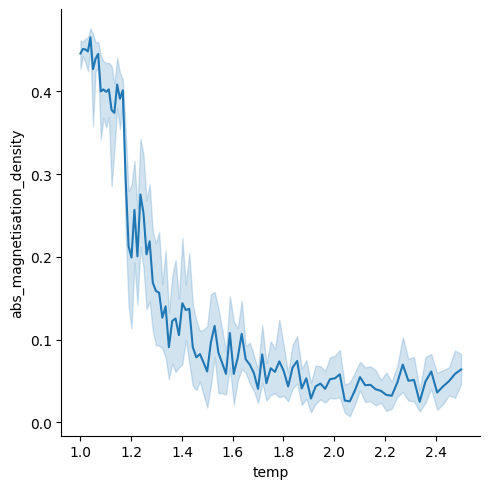

In [ ]:
fig_evolve_energy_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="energy",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_energy_sweeps.savefig(SAVE_PATH / "fig_evolve_energy_sweeps.png")

fig_evolve_therm_fit = sns.relplot(
    data=evolve_meas_fit_df,
    x="temp",
    y="therm_decay",
)
fig_evolve_therm_fit.savefig(SAVE_PATH / "fig_evolve_therm_fit.png")

fig_evolve_mag_dens_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="magnetisation_density",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_mag_dens_sweeps.savefig(SAVE_PATH / "fig_evolve_mag_dens_sweeps.png")

last_sweeps = evolve_meas_df[
    evolve_meas_df["sweeps"] == np.max(evolve_meas_df["sweeps"])
]

fig_evolve_energy_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="energy",
    # hue="beta",
    kind="line",
    # errorbar=None
)
fig_evolve_energy_temp.savefig(SAVE_PATH / "fig_evolve_energy_temp.png")

fig_evolve_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="magnetisation_density",
)
fig_evolve_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_mag_dens_temp.png")

fig_evolve_abs_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="abs_magnetisation_density",
    kind="line",
    # errorbar=None
)
fig_evolve_abs_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_abs_mag_dens_temp.png")

In [ ]:
states_list = states.unensamble()
temp_states = states_list[: c.n_temps]

In [ ]:
@interact(value=0, min=0, max=len(temp_states))
def update(i=(0, len(temp_states) - 1)):
    fig = temp_states[i].plot()
    fig.set_size_inches(10, 10)
    fig.dpi = 100


...

interactive(children=(IntSlider(value=47, description='i', max=95), Output()), _dom_classes=('widget-interact'…

Ellipsis

In [ ]:
if not has_thermalised:
    raise RuntimeError("System has not fully thermalised!")

# Autocorrelation

In [ ]:
if c.do_autocorrelation:

    @transforms(in_axes=(0, 0, None, None, None), out_axes=0)
    def get_autocorrelation(
        key: RNGKey, state: State, steps: int, sweeps_per_step: int, num_prints: int
    ) -> AutocorrelationData:
        keys = random.split(key, num=steps)

        def get_measurement_scan(state: State, x: RNGKey) -> tuple[State, Measurement]:
            rng_key = x
            state = state.evolve_sweeps(rng_key=rng_key, sweeps=sweeps_per_step)
            measurement = state.measure()

            return state, measurement

        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=get_measurement_scan, init=state, xs=keys)

        acorr_energy = acf(measurements.energy)
        acorr_mag_dens = acf(jnp.abs(measurements.magnetisation_density))

        sweeps = jnp.arange(acorr_energy.size) * sweeps_per_step

        # Fit exponential decay to find characteristic autocorrelation time
        def exponential_decay(x, tau):
            """
            f(x) = exp(- x / τ)
            """
            return jnp.exp(-x / tau)

        # Objective function to minimise
        def objective(params, x, y, weights):
            tau = params
            trial = exponential_decay(x, tau)
            residuals = y - trial
            weighted_residuals = weights * residuals

            return jnp.sum(weighted_residuals**2)

        energy_initial_params = jnp.asarray([float(sweeps_per_step)])
        # Noise at high x (low y) dominates fit.
        # Weigh by ordinate magnitude
        energy_weights = jnp.abs(acorr_energy)
        energy_decay_time = minimize(
            objective,
            x0=energy_initial_params,
            method="BFGS",
            args=(sweeps, acorr_energy, energy_weights),
        ).x[0]

        mag_dens_initial_params = jnp.asarray([float(sweeps_per_step)])
        mag_dens_weights = jnp.abs(acorr_mag_dens)
        mag_dens_decay_time = minimize(
            objective,
            x0=mag_dens_initial_params,
            method="BFGS",
            args=(sweeps, acorr_mag_dens, mag_dens_weights),
        ).x[0]

        return AutocorrelationData(
            state=state,
            steps=steps,
            sweeps_per_step=sweeps_per_step,
            sweeps=sweeps,
            energy=acorr_energy,
            magnetisation_density=acorr_mag_dens,
            energy_decay_time=energy_decay_time,
            magnetisation_density_decay_time=mag_dens_decay_time,
        )

    keys = k.shaped(states.vectorisation_shape)
    # ac_data = get_autocorrelation(
    #     keys, states, c.autocorrelation_steps, c.autocorrelation_sweeps_per_step, 5
    # )
    ac_data = get_autocorrelation(keys, states, 5000, 2, 10)
    ac_data.block_until_ready()

In [ ]:
if c.do_autocorrelation:
    ac_df = ac_data.to_df()
    ac_df["temp"] = beta_to_temp(ac_df["state.env.beta"], human=True)
    ac_df_expl = ac_df.explode(
        ["energy", "magnetisation_density", "sweeps"]
    ).infer_objects()

    ac_df_expl["energy_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["energy_decay_time"]
    )
    ac_df_expl["mag_dens_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["magnetisation_density_decay_time"]
    )

    display(ac_df)
    display(ac_df_expl)

    ac_df.reset_index().to_feather(SAVE_PATH / "ac_df.feather")
    ac_df_expl.reset_index().to_feather(SAVE_PATH / "ac_df_expl.feather")

In [ ]:
if c.do_autocorrelation:
    fig_autocorrelation_energy = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_energy.savefig(SAVE_PATH / "fig_autocorrelation_energy.png")

    fig_autocorrelation_mag_dens = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="magnetisation_density",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="mag_dens_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_mag_dens.savefig(SAVE_PATH / "fig_autocorrelation_mag_dens.png")

    fig_autocorrelation_decay_times, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    sns.lineplot(
        data=ac_df,
        x="temp",
        y="energy_decay_time",
        ax=ax1,
        # y=["energy_decay_time", "magnetisation_density_decay_time"])
    )
    sns.lineplot(
        data=ac_df,
        x="temp",
        y="magnetisation_density_decay_time",
        ax=ax2,
        color="orange",
        # y=["energy_decay_time", "magnetisation_density_decay_time"])
    )
    plt.show()
    fig_autocorrelation_decay_times.savefig(
        SAVE_PATH / "fig_autocorrelation_decay_times.png"
    )

# Measure Equilibrium

In [ ]:
# @eqx.filter_vmap(in_axes=(0, None, None))
# def evolve_and_measure(rng_key: RNGKey, state: State, sweeps: int) -> Measurement:
#     state = state.evolve_sweeps(rng_key=rng_key, sweeps=sweeps)
#     measurement = state.measure()

#     return measurement


@transforms(in_axes=(0, 0, None, None, None, None), out_axes=0)
def measure_equilibrium(
    key: RNGKey, state: State, steps: int, num: int, sweeps: int, num_prints: int
) -> Measurement:
    def body_fun(carry: State, x: RNGKey):
        _rng_key = x
        measurements = carry.evolve_and_measure_multiple(
            rng_key=_rng_key, num=num, sweeps=sweeps
        )

        return carry, measurements

    keys = random.split(key=key, num=steps)
    scan = make_scan(
        tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
    )
    state, measurements = scan(f=body_fun, init=state, xs=keys)

    return measurements


keys = k.shaped(states.vectorisation_shape)
equil_measurements = measure_equilibrium(
    keys,
    states,
    c.measure_equilibrium_steps,
    c.measure_equilibrium_num,
    c.measure_equilibrium_sweeps_per_step,
    5,
)
equil_measurements.block_until_ready()

/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function scan includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


  0%|          | 0/960 [00:00<?, ?it/s]

In [ ]:
raise ValueError

ValueError: 

In [ ]:
_eq_df = equil_measurements.to_df()
eq_df["beta"] = eq_df["state_id"].apply(id_to_beta)
eq_df["temperature"] = beta_to_temp(eq_df["beta"], human=True)

eq_df = _eq_df.explode(_eq_df.columns.tolist())

Exception ignored in: <function _xla_gc_callback at 0x7f41ec70bb00>
Traceback (most recent call last):
  File "/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


In [ ]:
eq_df

,steps,sweeps,state_id,energy,magnetisation_density,beta,temperature
0,33874,10025,0,-3492.0,0.009888,0.4,2.5
0,33854,10025,0,-3512.0,0.010742,0.4,2.5
0,33864,10025,0,-3530.0,0.011108,0.4,2.5
0,33864,10025,0,-3498.0,0.012695,0.4,2.5
1,33864,10025,0,-3486.0,0.012695,0.4,2.5
...,...,...,...,...,...,...,...
638,136150941,10025,63,-14182.0,-0.449036,1.0,1.0
639,136180644,10025,63,-14394.0,-0.457886,1.0,1.0
639,136181817,10025,63,-14372.0,-0.45575,1.0,1.0
639,136135932,10025,63,-14294.0,0.455078,1.0,1.0


In [ ]:
# Create two dataframes of different 'shapes'
# sin_df: holds data that is defined on every state
# sum_df: holds data that requires grouping on states

sin_df = eq_df.copy()
sin_df["natural_temperature"] = 1.0 / sin_df["beta"]
sin_df["abs_magnetisation_density"] = np.abs(sin_df["magnetisation_density"])

sum_df = pd.DataFrame()

# Energy - Summarised
sum_df["energies_mean"] = eq_df.groupby(["state_id"])["energy"].mean()
sum_df["energies_var"] = eq_df.groupby(["state_id"])["energy"].var()

# Magnetisation Density - Summarised
sum_df["mag_dens_mean"] = eq_df.groupby(["state_id"])["magnetisation_density"].mean()
sum_df["mag_dens_var"] = eq_df.groupby(["state_id"])["magnetisation_density"].var()

# # Index
sum_df = sum_df.reset_index()

# Temperature + Coldness
sum_df["beta"] = sum_df["state_id"].apply(id_to_beta)
sum_df["temperature"] = beta_to_temp(sum_df["beta"])
sum_df["natural_temperature"] = beta_to_temp(sum_df["beta"], human=True)

# Heat Capacity
sum_df["heat_cap_gradient"] = np.abs(
    np.gradient(sum_df["energies_mean"], sum_df["temperature"])
)
sum_df["heat_cap_fluctuation"] = sum_df["energies_var"] / (
    constants.Boltzmann * np.square(sum_df["temperature"])
)

# Magnetic Susceptibility
sum_df["mag_sus_gradient"] = np.abs(
    np.gradient(sum_df["mag_dens_mean"], sum_df["temperature"])
)
sum_df["mag_sus_fluctuation"] = sum_df["mag_dens_var"] / (
    constants.Boltzmann * np.square(sum_df["temperature"])
)

# Binder cumulant
sin_df["mag_1"] = np.abs(eq_df["magnetisation_density"])
sin_df["mag_2"] = np.power(eq_df["magnetisation_density"], 2)
sin_df["mag_4"] = np.power(eq_df["magnetisation_density"], 4)

sum_df["mag_1_mean"] = sin_df.groupby("state_id")["mag_1"].mean()
sum_df["mag_2_mean"] = sin_df.groupby("state_id")["mag_2"].mean()
sum_df["mag_4_mean"] = sin_df.groupby("state_id")["mag_4"].mean()

sum_df["binder_2"] = 1 - sum_df["mag_2_mean"] / np.square(sum_df["mag_1_mean"])
sum_df["binder_4"] = 1.0 / 3.0 - sum_df["mag_4_mean"] / (
    3.0 * np.square(sum_df["mag_2_mean"])
)

sin_df.reset_index().to_feather(SAVE_PATH / "sin_df.feather")
sum_df.reset_index().to_feather(SAVE_PATH / "sum_df.feather")

/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:1241: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:1248: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:1257: RuntimeWarning: divide by zero encountered in scalar divide
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
/home/j

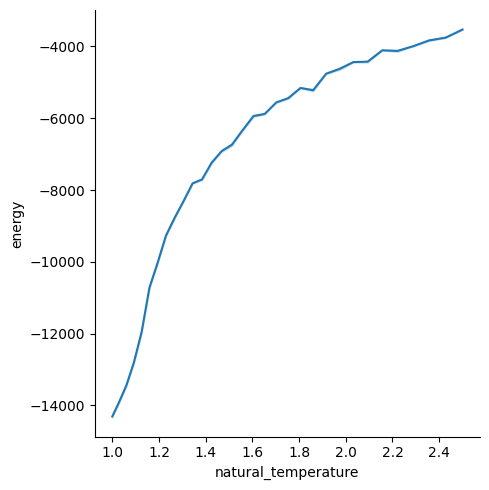

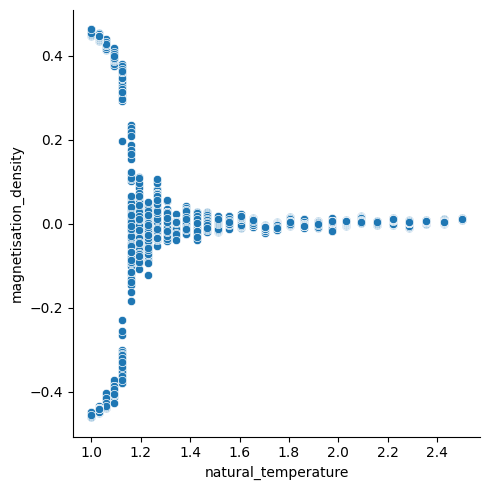

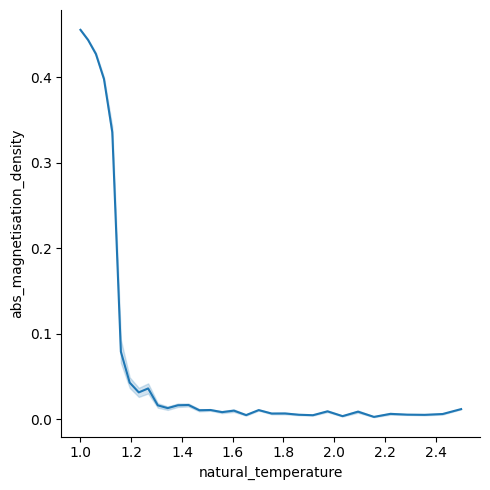

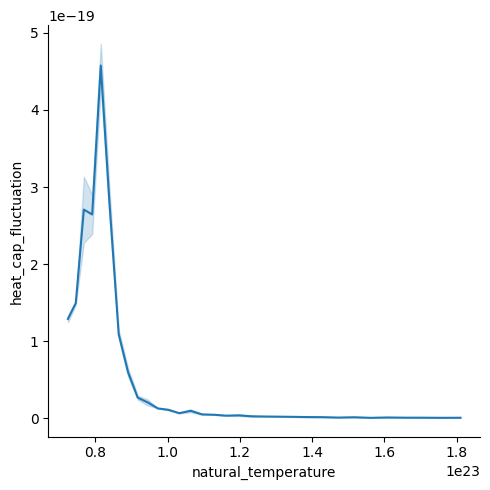

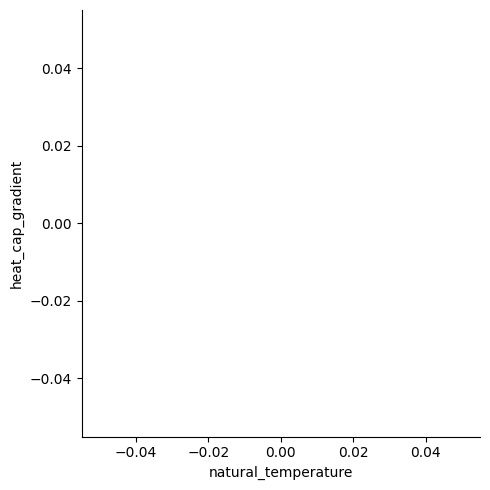

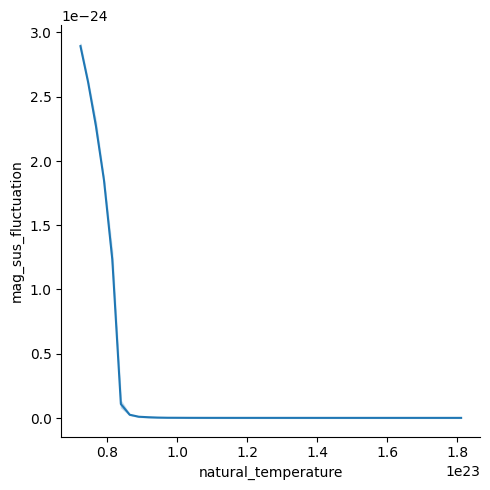

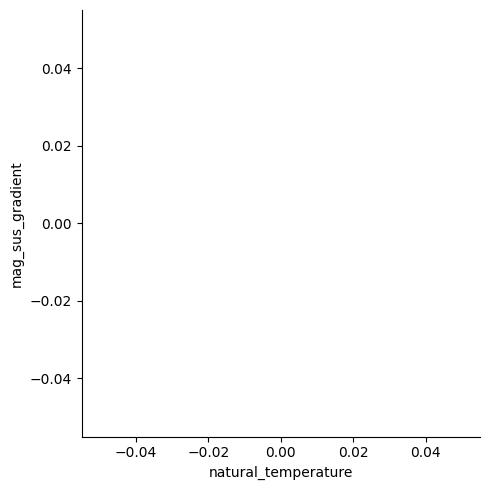

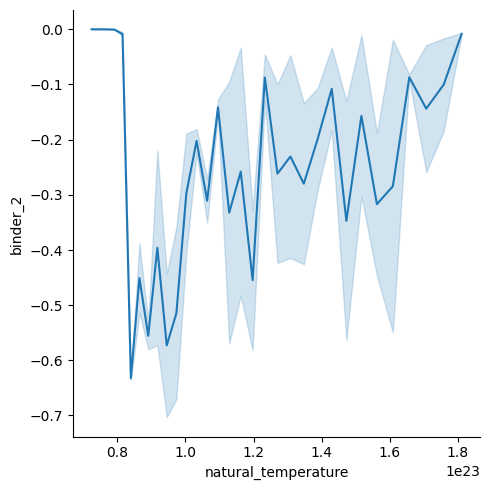

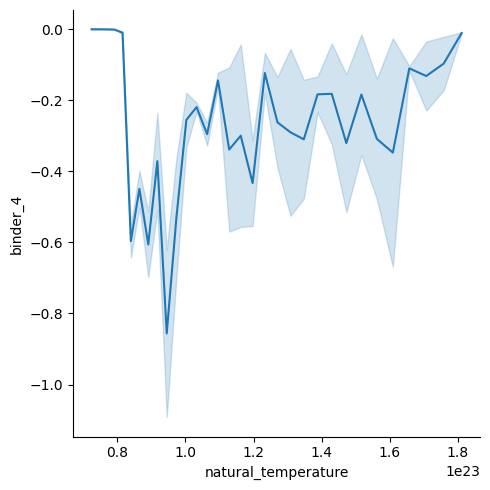

In [ ]:
fig_measure_energy_temp = sns.relplot(
    data=sin_df,
    x="natural_temperature",
    y="energy",
    kind="line",
)
fig_measure_energy_temp.savefig(SAVE_PATH / "fig_measure_energy_temp.png")

fig_measure_mag_dens_temp = sns.relplot(
    data=sin_df,
    x="natural_temperature",
    y="magnetisation_density",
    # kind="line",
)
fig_measure_mag_dens_temp.savefig(SAVE_PATH / "fig_measure_mag_dens_temp.png")

fig_measure_abs_mag_dens_temp = sns.relplot(
    data=sin_df,
    x="natural_temperature",
    y="abs_magnetisation_density",
    kind="line",
)
fig_measure_abs_mag_dens_temp.savefig(SAVE_PATH / "fig_measure_abs_mag_dens_temp.png")

fig_measure_heat_cap_fluctuation_temp = sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="heat_cap_fluctuation",
    kind="line",
)
fig_measure_heat_cap_fluctuation_temp.savefig(
    SAVE_PATH / "fig_measure_heat_cap_fluctuation_temp.png"
)

fig_measure_heat_cap_gradient_temp = sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="heat_cap_gradient",
    kind="line",
)
fig_measure_heat_cap_gradient_temp.savefig(
    SAVE_PATH / "fig_measure_heat_cap_gradient_temp.png"
)

fig_measure_mag_sus_fluctuation_temp = sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="mag_sus_fluctuation",
    kind="line",
)
fig_measure_mag_sus_fluctuation_temp.savefig(
    SAVE_PATH / "fig_measure_mag_sus_fluctuation_temp.png"
)

fig_measure_mag_sus_gradient_temp = sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="mag_sus_gradient",
    kind="line",
)
fig_measure_mag_sus_gradient_temp.savefig(
    SAVE_PATH / "fig_measure_mag_sus_gradient_temp.png"
)

fig_measure_binder_2 = sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="binder_2",
    kind="line",
)
fig_measure_binder_2.savefig(SAVE_PATH / "fig_measure_binder_2.png")

fig_measure_binder_4 = sns.relplot(
    data=sum_df,
    x="natural_temperature",
    y="binder_4",
    kind="line",
)
fig_measure_binder_4.savefig(SAVE_PATH / "fig_measure_binder_4.png")

In [ ]:
with open(SAVE_PATH / "saved_variables.json", "w") as f:
    json.dump(
        to_save, f, indent=4, sort_keys=True, ensure_ascii=False, cls=NumpyEncoder
    )